In [141]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib

from ATARI.sammy_interface import sammy_classes, sammy_functions

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy, deepcopy

import plotting as myplot


In [142]:
sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'

In [143]:
%matplotlib widget

# Overview

The synthetic data methodology build here is modeled after measurement data from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
This notebook investigates the 1, 3, and 6 mm transmission measurements.

## 1, 3, & 6 mm Transmission Measurements

For these measurement models, we do not have access to the raw data or the full data-reduction model like we did for the 12mm validation case.
Instead, we only have access to the published journal article for the measurements, an appropriate resolution function, and the reduced data in EXFOR.
We must glean the necessary information for the ATARI.syndat measurement models from these sources.

In [144]:
from ATARI.syndat import syndat_model
importlib.reload(syndat_model)
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT

In [145]:

### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc



energy_range_T = [0.15e3, 200e3]

### 1mm Transmission data
transdat1 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-1mm.twenty"))
transdat1_covfile = os.path.realpath('./data/trans-Ta-1mm.idc')

chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)

exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 
                               energy_range = energy_range_T,
                                energy_grid = np.sort(transdat1.E.values),
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1.loc[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range)), :]

### 3mm transmission data
transdat3 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-3mm.twenty"))
transdat3_covfile = os.path.realpath("./data/trans-Ta-3mm.idc")

exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               energy_range = energy_range_T,
                                energy_grid = np.sort(transdat3.E.values),
                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat3 = transdat3.loc[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range)), :]


### 6mm transmission data
transdat6 = sammy_functions.readlst(os.path.realpath("./data/trans-Ta-6mm.twenty"))
transdat6_covfile = os.path.realpath("./data/trans-Ta-6mm.idc")

exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = energy_range_T,
                                energy_grid = np.sort(transdat6.E.values),
                                # energy_grid = np.sort(transdat12.E.values),
                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat6 = transdat6.loc[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range)), :]

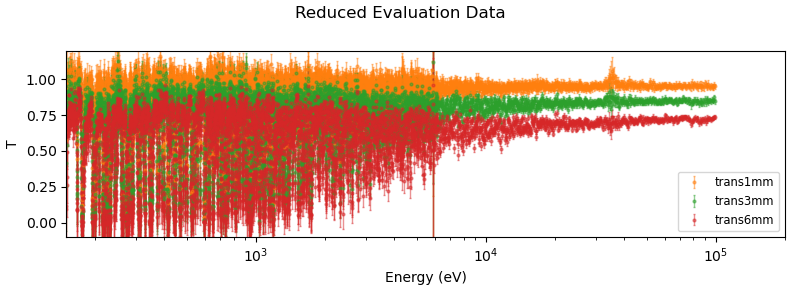

In [146]:
importlib.reload(myplot)
### setup in zipped lists 
datasets = [transdat1, transdat3, transdat6]
experiments= [exptrans1, exptrans3, exptrans6]

covariance_data = [transdat1_covfile, transdat3_covfile, transdat6_covfile]
for exp in experiments:
    filepath = f'./data/template_{exp.title}_edited'
    exp.template = os.path.realpath(filepath)

fig = myplot.plot_reduced_data_T(datasets, experiments,
                                 xlim=energy_range_T, #(.15e3, 2.5e3),
                               fig_size=(8,3))
fig.suptitle("Reduced Evaluation Data")
fig.tight_layout()
# fig_trans_real.show()


### Approximate the resonances that generated this data

Synthetic data can be generated around any point-wise vector (of the experimental object transmission or capture yield) that is taken as 'true'.
In order to better compare synthetic data to real data, we must approximate the resonance structures that generated the real data and use those as 'true'
For this, you can take the evaluated JEFF parameters or fit the new data from those parameters.
Because we have multiple datasets, the sammy_YW scheme can be used to fit all 3 simultaneously.


In [147]:
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True
                              })

matnum = 7328
jeff_file = os.path.realpath("./data/73-Ta-181g.jeff33")
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, rto)

energy_range_all = (4, 2500)
jeff_parameters = jeff_parameters[(jeff_parameters.E<max(energy_range_T)) & (jeff_parameters.E>min(energy_range_T))]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))


### setup the reaction model - Ta-181 is the default
Ta_pair = Particle_Pair()      

sammyINPyw = sammy_classes.SammyInputDataYW(
    Ta_pair,
    resonance_ladder=jeff_parameters,

    datasets = datasets ,
    experiments= experiments,
    experimental_covariance = covariance_data,

    max_steps = 1,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = False,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 1
)

sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)
print(sammyOUT.chi2)
print(sammyOUT.chi2_post)

KeyboardInterrupt: 

## Unknown measurement model
<!-- ![EvalT_RawData.png](attachment:EvalT_RawData.png) -->
The most challenging aspect of building a measurement model without full access to raw data is approximating the neutron and background spectra.
In this case, a spectrum and fitted background function are published in the journal article.
Here we will 'guess-and-check' parameters that create a similar picture.

<!-- <img src="./data/EvalT_RawData.png" alt="Alt text" width="500" height="300"> -->


#### Estimating the background

For the transmission methodology here, parameters b0o and b0s are independent measurements of a constant background for open and sample measurements respectively.
Parameters ko and ks are independent parameters estimated by the fixed notch resonance present during the open and sample measurements respectively.
Parameters a and b are used to represent the time-dependent background.
These parameters are correlated to one another and are estimated from a separate set of measurements.

Count rate for each of the notch points can be 'eye-balled'.
Additionaly, these notches correspond to strong (blackout) resonances in standard isotopes so the time-of-flight can be precisely deduced.

Uncertainties on k and b0 are independent and are given by counting statistics during the actual open and sample measurements.
Uncertainties on the a and b parameters are correlated and estimated by the goodness of fit to the notches in the background measurements.

Because we need to infer all of these parameters, and the published graph shows the object $bi*k*b0$, we can fit the entire model to our data.
Covariance estimates here given by goodness of fit will be much too large and include correlations on uncorrelated parameters.
To address this, we can take the estimates for the independent parameters as the independent, measured value and give some estimated uncertainty (5% here).
Then, taking those independent parameters as fixed, we can refit the a and b parameters to the object $bi$. 
This will fine-tune these parameters and give a more appropriate covariance based on goodness of fit.

#### Estimating the open spectrum
 
The open spectrum, for obvious reasons, will not be replicated near as well.
For the ideal synthetic data case you will have a measured open spectrum, however, that is not always possible.
Fortunately, the inherent 'cleanliness' of a transmission measurement makes this not such a big deal. 
Transmission is a ratio of sample-to-open spectra, and each spectrum is taken at the same facility under identical conditions (except for the presence of the target sample).
Because of this, experimentalists do not need to characterize the incident neutron flux under the assumptions that any features -- other than those induced by the target sample -- cancel one another out. 
In the same way, any improper approximation to the open spectra for synthetic data generation will cancel out.
So, reproducing just the general shape and magnitude should suffice.

Furthermore, this data is reported to be reliable between 0.15 keV and 100 keV, and the resolved resonance region ends around 3 keV.
Within the region 0.15-3 keV, the shape of the open spectrum is nearly identical to the background and does not include any extraneous features, such as the fixed notch of Co-59.



In [396]:
from ATARI.syndat import general_functions
from scipy.optimize import curve_fit

### Initial estimates of trig
trigo = 3e7
# trigs = 2e7

t0=exptrans1.t0[0]
FP = exptrans1.FP[0]


In [397]:
# fit approximate notches to estimate parameters & covariance for background
def Bi_power(tof,a,b):
    return a*(tof**(-b))

def func(tof, a, b, ko, ks, b0o, b0s):
    bi = Bi_power(tof, a, b)
    k = np.array([ko] * int(len(tof)/2) + [ks] * int(len(tof)/2))
    b0 = np.array([b0o] * int(len(tof)/2) + [b0s] * int(len(tof)/2))
    return bi*k*b0

# estimated notches during background runs
bgp_s = np.array([2.1e3, 1.3e3,  6e2, 2.1e2])
bgp_o = np.array([2.8e3, 2.0e3, 8e2, 3e2])
bgE = np.array([84e3, 35e3, 2.8e3, 0.33e3])
bgtof = e_to_t(np.array(bgE), 100.14, True)*1e6

# eatimated cobalt fixed notch during production runs
Co_o = 1.9e2
Co_s = 1.3e2
CoE = 0.132e3
Cotof = e_to_t(np.array(CoE), 100.14, True)*1e6


### def get_initial_estimates():
initial = [1000, 1, 1,1, 10,10]
bounds = ([0,0, 0.2,0.2, 0,0],
        [np.inf, np.inf, 2,2, 100,100])

x = np.concatenate([bgtof, [Cotof], bgtof, [Cotof]])
y = np.concatenate([bgp_o, [Co_o], bgp_s, [Co_s]])

popt, _ = curve_fit(func, x, y, p0=initial)#, sigma=y*1e-5, absolute_sigma=True)
a,b, ko,ks, b0o, b0s = popt
# da,db, dko,dks, db0o, db0s = np.sqrt(np.diag(pcov))
# print(popt)
# print(np.sqrt(np.diag(pcov)))


### get better covariance estimate for a,b given other parameters
x2 = x
y2 = np.concatenate([bgp_o/ko-b0o, [Co_o/ko-b0o], bgp_s/ks-b0s, [Co_s/ks-b0s]])
popt2, abcov = curve_fit(Bi_power, x2, y2, p0=[a,b])
a,b = popt2
da,db = np.sqrt(np.diag(abcov))
# print("2")
# print(popt2)
# print(np.sqrt(np.diag(pcov2)))


### printout 
dko = ko*0.05
dks = ks*0.05
db0o = b0o*0.05
db0s = b0s*0.05

print("Estimated reduction parameters")

print()
print("Background function covariance is estimated based on the residual of the notch data to the fit")
print(f"a, da = {np.round(a, 3)}, {np.round(da, 3)}")
print(f"b, db = {np.round(b, 3)}, {np.round(db, 3)}")
print(f"%db   = {np.round(db/b, 3)} (reference reports 6% - we are close!)")
print()
print(f"ab covariance = \n{abcov}")


print()
print("The following, independent parameters' uncertainty is estimated conservatively to be 4%")
print(f"ko, dko   = {np.round(ko, 3)},{np.round(dko, 3)}")
print(f"ks, dks   = {np.round(ks, 3)},{np.round(dks, 3)}")
print(f"b0o, db0o = {np.round(b0o, 3)},{np.round(db0o, 3)}")
print(f"b0s, db0s = {np.round(b0s, 3)},{np.round(db0s, 3)}")


Estimated reduction parameters

Background function covariance is estimated based on the residual of the notch data to the fit
a, da = 24265.832, 4002.64
b, db = 0.814, 0.047
%db   = 0.058 (reference reports 6% - we are close!)

ab covariance = 
[[1.60211286e+07 1.87901859e+02]
 [1.87901859e+02 2.24240657e-03]]

The following, independent parameters' uncertainty is estimated conservatively to be 4%
ko, dko   = 1.528,0.076
ks, dks   = 1.179,0.059
b0o, db0o = 15.392,0.77
b0s, db0s = 14.311,0.716


In [398]:
### fit open spectrum from approximate points, same functional form as background 
co =    np.array([3e3,  2e3,      1.5e3,   9e2,    6e2,   3e2, 3e2])
tof_o = np.array([9e1,  1.6e2,    2e2,     3e2,    5e2,   8e2, 9e2])

def open_exp(tof, a, b):#, b0):
    return a*(tof**(-b)) #(a * np.exp(-b * tof) )#+ b0) 

popt, _ = curve_fit(open_exp, tof_o, co)
ao, bo = popt
print("open")
print(popt)

# tof = e_to_t(exptrans1.tof_grid, FP, True)*1e9 + t0 
tof = exptrans1.tof_grid*1e-3
cps_open_smooth = open_exp(tof, *popt)

bin_width = abs(np.append(np.diff(tof), np.diff(tof)[-1])*1e-6)
cts_open_approx = cps_open_smooth * bin_width * trigo
cts_open_measured = general_functions.pois_noise(cts_open_approx)

open_dataframe = pd.DataFrame({'tof'    :   tof,
                                'bw'    :   bin_width,
                                'ct'     :   cts_open_measured,
                                'dct'    :   np.sqrt(cts_open_measured)})

open_dataframe['E'] = exptrans1.energy_grid#t_to_e((open_dataframe.tof-t0)*1e-9, FP, True) 
open_dataframe['c'], open_dataframe['dc'] = general_functions.cts_to_ctr(open_dataframe.ct, open_dataframe.dct, open_dataframe.bw, trigo)

open
[2.11544534e+05 9.39522842e-01]


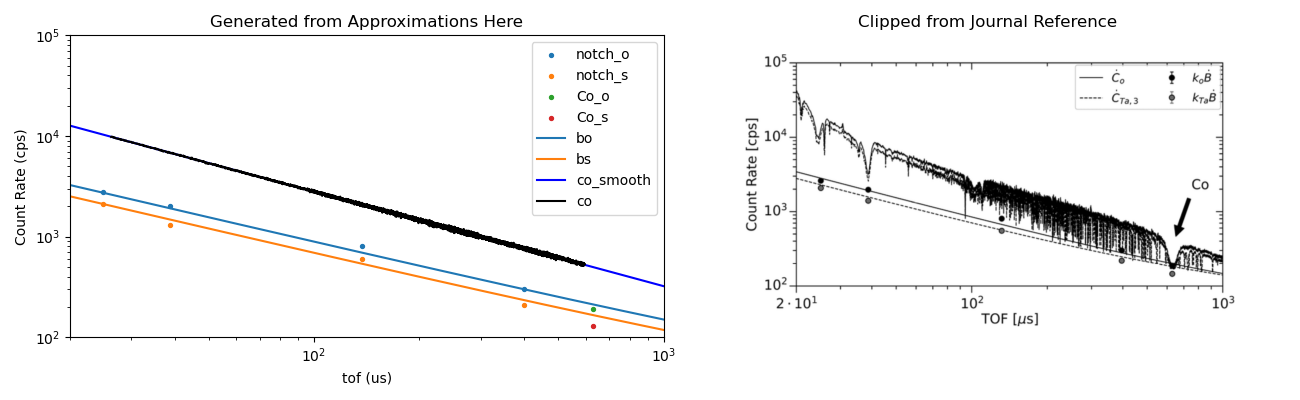

In [399]:
from PIL import Image
# journal_image = np.asarray(Image.open('./data/EvalT_RawData.png'))
journal_image = Image.open('./data/EvalT_RawData.png')



fake_tof = np.linspace(2e1,1e3, 1000)
Bi = Bi_power(fake_tof, a,b)

fig, axes = subplots(1,2, figsize=(13,4))

axes[0].scatter(bgtof, bgp_o, label='notch_o', s=8)
axes[0].scatter(bgtof, bgp_s, label='notch_s', s=8)
axes[0].scatter(Cotof, Co_o, label='Co_o', s=8)
axes[0].scatter(Cotof, Co_s, label='Co_s', s=8)

axes[0].plot(fake_tof, Bi*ko+b0o, label='bo')
axes[0].plot(fake_tof, Bi*ks+b0s, label='bs')

axes[0].plot(fake_tof, open_exp(fake_tof, *popt), 'b', label='co_smooth')
axes[0].plot(open_dataframe.tof, open_dataframe.c, color='k', label='co')
# plot(fake_tof, open_exp(fake_tof, *popt), 'b', label='co_smooth')

axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_ylim(1e2, 1e5)
axes[0].set_xlim(2e1, 1e3)
axes[0].set_ylabel('Count Rate (cps)')
axes[0].set_xlabel('tof (us)')
axes[0].legend()
axes[0].set_title("Generated from Approximations Here")

imgplot = axes[1].imshow(journal_image)
axes[1].axis('off')
axes[1].set_title("Clipped from Journal Reference")

fig.tight_layout()

In [400]:
def plot_behind():
        # from PIL import Image

    # im = imread('./data/EvalT_RawData.png')

    # fake_tof = np.linspace(2e1,1e3, 1000)
    # Bi = Bi_power(fake_tof, a,b)

    # figure(figsize=(10,5))

    # # rcParams["figure.figsize"] = [7.00, 3.50]
    # # rcParams["figure.autolayout"] = True
    # ax = gca()
    # im = ax.imshow(im)#, extent=[0, 300, 0, 300])


    # scatter(bgtof, bgp_o, label='notch_o', s=5)
    # scatter(bgtof, bgp_s, label='notch_s', s=5)
    # scatter(Cotof, Co_o, label='Co_o', s=5)
    # scatter(Cotof, Co_s, label='Co_s', s=5)

    # plot(fake_tof, Bi*ko+b0o, label='bo')
    # plot(fake_tof, Bi*ks+b0s, label='bs')

    # plot(fake_tof, open_exp(fake_tof, *popt), 'b', label='co_smooth')
    # plot(open_dataframe.tof, open_dataframe.c, color='k', label='co')
    # # plot(fake_tof, open_exp(fake_tof, *popt), 'b', label='co_smooth')

    # # imgplot = imshow(img)

    # yscale('log')
    # xscale('log')
    # ylim(1e2, 1e5)
    # xlim(2e1, 1e3)
    # ylabel('Count Rate (cps)')
    # xlabel('tof (us)')
    # legend()
    # tight_layout
    return

### generate synthetic data with approximated measurement parameters

In [401]:
tbw=1e7*2.5e-6
print(0.563, np.sqrt(0.563/tbw),        0.02402339737495515)
print(1.471, np.sqrt(1.471/tbw),        0.05576763648617445)
print(9.9, np.sqrt(9.9/tbw),          0.1)
print(13.4, np.sqrt(13.4/tbw),         0.7)

0.563 0.15006665185843254 0.02402339737495515
1.471 0.24256957764732162 0.05576763648617445
9.9 0.6292853089020909 0.1
13.4 0.732120208708925 0.7


In [402]:
par

{'trigo': (10000000.0, 0),
 'trigs': (1000000000000000.0, 0),
 'ks': (1.679455309715703, 0.038972765485785155),
 'ko': (2.527894653813204, 0.0563947326906602),
 'b0s': (14.310802074695845, 0.21554010373479227),
 'b0o': (15.39156738378266, 0.46957836918913304),
 'a_b': ([24265.831876599997, 0.8136939210769795],
  array([[1.60211286e+07, 1.87901859e+02],
         [1.87901859e+02, 2.24240657e-03]]))}

In [434]:
from ATARI.syndat import syndat_model
importlib.reload(syndat_model)
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat import control 
importlib.reload(control)
importlib.reload(myplot)


par = {
'trigo' :   (trigo,  0),
'trigs' :   (5e7,  0), #trigs
'ks'    :   (ks+0.5,        dks-0.02),
'ko'    :   (ko+0.5,          dko-0.02),
'b0s'   :   (b0s+5,           db0s-0.5),
'b0o'   :   (b0o,         db0o-0.3),
'a_b'   :  ([a, b],         abcov)
}

# syndat takes tof in nanoseconds
open_dataframe_syndat  = copy(open_dataframe)
open_dataframe_syndat['tof'] = open_dataframe_syndat['tof']*1e3
open_dataframe_syndat

trans1mm_gen_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe_syndat,
                                    bkg_func = 'power')
trans1mm_red_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe_syndat,
                                    bkg_func = 'power')

trans3mm_gen_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe_syndat,
                                    bkg_func = 'power')
trans3mm_red_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe_syndat,
                                    bkg_func = 'power')

trans6mm_gen_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe_syndat,
                                    bkg_func = 'power')
trans6mm_red_meas = Transmission_RPI(**par, 
                                    open_neutron_spectrum = open_dataframe_syndat,
                                    bkg_func = 'power')

In [435]:
### define syndat options and model, do not sample resonances
synOPT = control.syndatOPT(sampleRES=False, calculate_covariance=True, explicit_covariance=True, smoothTNCS=True, save_raw_data=True)

syndat_trans1mm = Syndat_Model(exptrans1,
                            trans1mm_gen_meas,
                            trans1mm_red_meas,
                            options = synOPT,
                            title='trans1mm')
syndat_trans3mm = Syndat_Model(exptrans3,
                            trans3mm_gen_meas,
                            trans3mm_red_meas,
                            options = synOPT,
                            title='trans3mm')
syndat_trans6mm = Syndat_Model(exptrans6,
                            trans6mm_gen_meas,
                            trans6mm_red_meas,
                            options = synOPT,
                            title='trans6mm')


### set the resonance ladder for the reaction model
Ta_pair.resonance_ladder = copy(sammyOUT.par_post)

### build syndat control module and draw samples
syndat = control.Syndat_Control(particle_pair= Ta_pair,
                        syndat_models = [syndat_trans1mm, syndat_trans3mm, syndat_trans6mm],
                        model_correlations = None,
                        options=synOPT
                        )

# pass pw true instead of recalculating model bc it is expensive ofer this energy range
pw_true_list = deepcopy(sammyOUT.pw_post)
[df.rename(columns={"theo_trans":'true'}, inplace=True) for df in pw_true_list]


rto.bayes = False
syndat.sample(rto, num_samples=1, pw_true_list=pw_true_list)

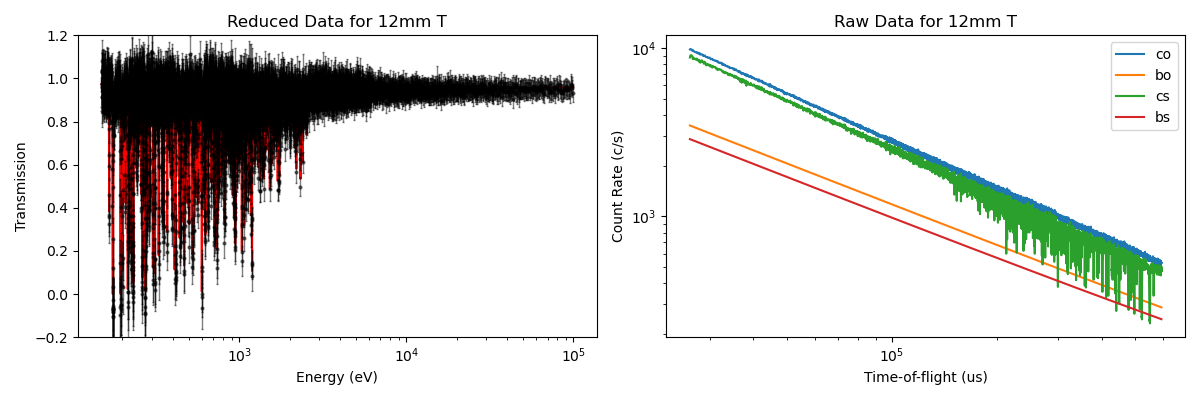

In [436]:
sample1 = syndat.get_sample(0)

red_data = sample1['trans1mm'].pw_reduced
raw_data = sample1['trans1mm'].pw_raw

# plot transmission
fig, axes = subplots(1,2, figsize=(12,4))

axes[0].errorbar(red_data.E, red_data.exp, yerr=red_data.exp_unc,
                  fmt='.', alpha=0.5, color='k', linewidth=1.0, markersize=4, capsize=1, label=exptrans1.title)
axes[0].plot(red_data.E, red_data.true, color='r', zorder=1)

axes[0].set_xscale('log')
# axes[0].set_yscale('log')
axes[0].set_ylim([-0.2, 1.2])
axes[0].set_xlabel("Energy (eV)")
axes[0].set_title("Reduced Data for 12mm T")
axes[0].set_ylabel("Transmission")


# axes[1].plot(raw_data.tof, raw_data.cto_true, label='co')
axes[1].plot(raw_data.tof, raw_data.co, label='co')
axes[1].plot(raw_data.tof, raw_data.bo, label='bo')

# axes[1].plot(raw_data.tof, raw_data.cts, label='cs')
axes[1].plot(raw_data.tof, raw_data.cs, label='cs')
axes[1].plot(raw_data.tof, raw_data.bs, label='bs')

axes[1].set_xscale('log')
axes[1].set_yscale('log')

axes[1].set_xlabel("Time-of-flight (us)")
axes[1].set_ylabel("Count Rate (c/s)")
axes[1].set_title("Raw Data for 12mm T")


# axes[2].imshow(trans12_explicit_covariance)
# imshow(trans12_explicit_covariance, vmin=-.1, vmax=.1)

# axes[2].colorbar()
axes[1].legend()

fig.tight_layout()

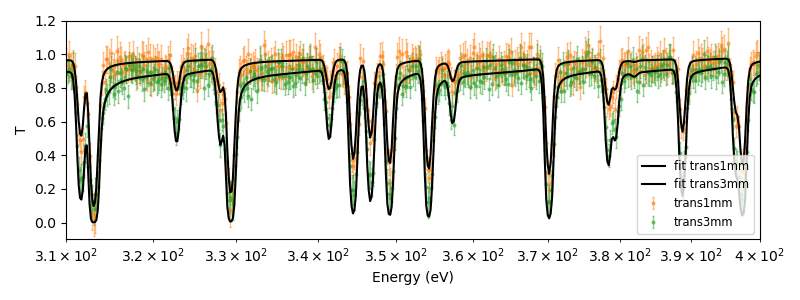

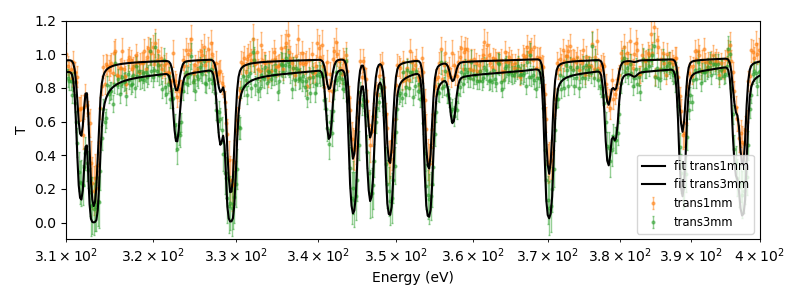

In [437]:

syndat_datasets = [out.pw_reduced for key, out in sample1.items()]
fig_synthetic = myplot.plot_reduced_data_T(syndat_datasets[:-1], experiments[:-1],
                                        xlim=(310, 400),#energy_range_T, #(.15e3, 2.5e3),
                                    fig_size=(8,3),
                                    fits=sammyOUT.pw_post)

fig_trans_real = myplot.plot_reduced_data_T(datasets[:-1], experiments[:-1],
                                 xlim=(310, 400),#energy_range_T
                               fig_size=(8,3),
                               fits=sammyOUT.pw_post)

# fig, axes = subplots(1,2)

# axes[0].imshow(fig_synthetic)
# axes[1].imshow(fig_trans_real)
# show()

# sample1['trans1mm'].experiment

### Comparing how the data is distributed

The following distributions are constructed after filtering the data to areas of the RRR that are well-represented by the fitted cross section (150< eV < 850).


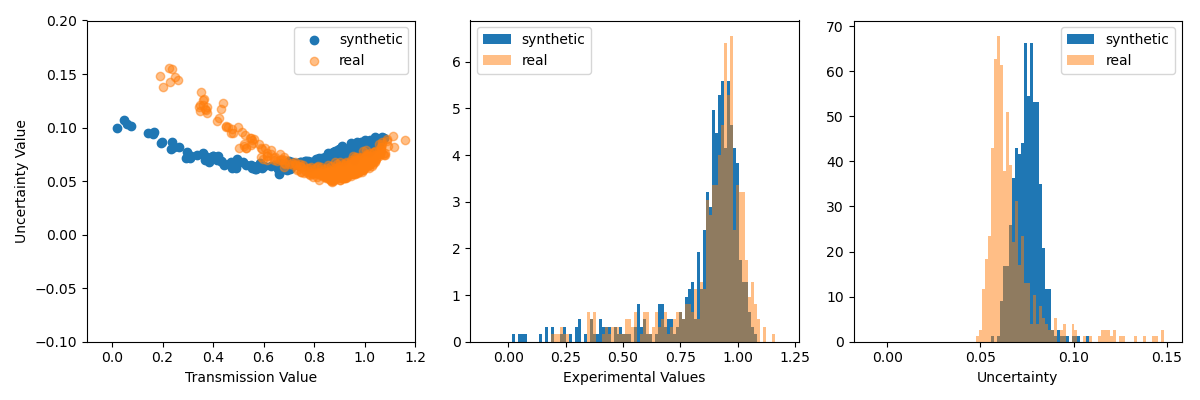

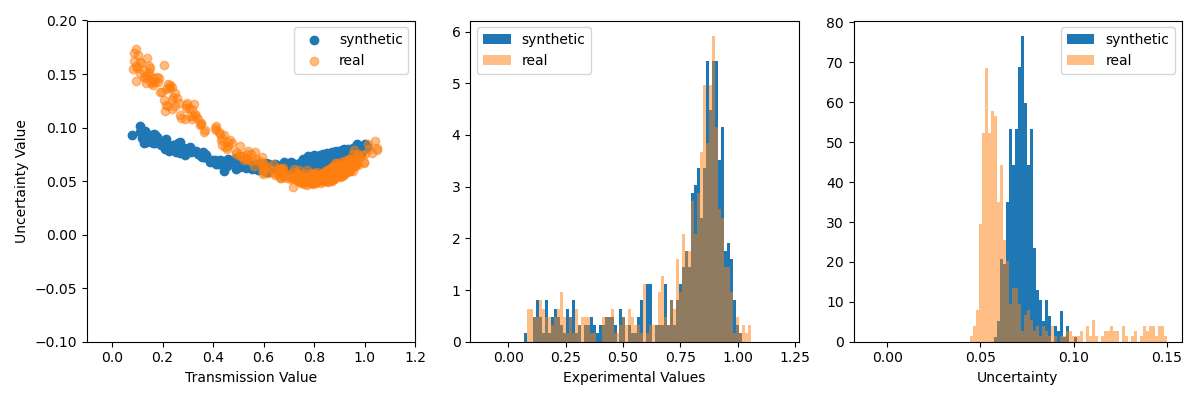

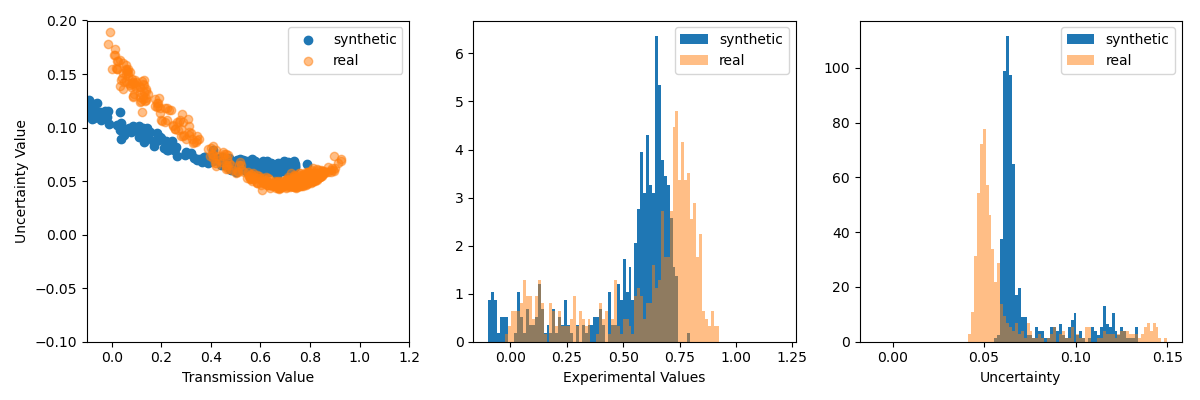

In [438]:

mask_syndat = (syndat_datasets[0].E>310.0) & (syndat_datasets[0].E<400)
mask_real= (datasets[0].E>310.0) & (datasets[0].E<400)

for syn, real in zip(syndat_datasets, datasets):
# syn = syndat_datasets[0]
# real = datasets[0]

    synthetic_data = syn[mask_syndat]
    real_data = real[mask_real]


    fig, axes = subplots(1,3, figsize=(12,4))

    axes[0].scatter(synthetic_data.exp, synthetic_data.exp_unc, label='synthetic')
    axes[0].scatter(real_data.exp, real_data.exp_unc, label='real', alpha=0.5)
    axes[0].set_xlim([-0.1,1.2])
    axes[0].set_ylim([-0.1, 0.2])
    axes[0].set_ylabel("Uncertainty Value")
    axes[0].set_xlabel("Transmission Value")

    bins = 100
    # range = (-4,4)
    # _ = axes[1].hist((synthetic_data.exp-synthetic_data.true)/synthetic_data.exp_unc, bins=bins, range=range, density=True,label='synthetic') #-red_data.true
    # _ = axes[1].hist((real_data.exp-synthetic_data.true)/real_data.exp_unc, bins=bins, range=range, alpha=0.5,density=True, label='real')#-red_data.true
    # axes[1].set_xlabel("Residuals")
    range = (-0.1, 1.2)
    _ = axes[1].hist((synthetic_data.exp), bins=bins, range=range, density=True,label='synthetic')  #-red_data.true
    _ = axes[1].hist((real_data.exp), bins=bins, range=range, alpha=0.5,density=True, label='real') #-red_data.true
    axes[1].set_xlabel("Experimental Values")

    bins = 100
    range = (-.01,.15)
    _ = axes[2].hist(synthetic_data.exp_unc, bins=bins, range=range, density=True,label='synthetic')
    _ = axes[2].hist(real_data.exp_unc, bins=bins, range=range, alpha=0.5, density=True,label='real')
    axes[2].set_xlabel("Uncertainty")

    for ax in axes:
        ax.legend()

    # fig.suptitle("")
    fig.tight_layout()